In [1]:
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from constants import FIGSIZE

In [2]:
def create_spectrogram() -> Tuple[plt.Figure, plt.Axes]:
    """
    Create a formatted MPL plot to display spectrogram data.
    """
    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.set_xlabel('Kanal')
    ax.set_ylabel('Intensität [a.u.]')
    ax.grid()

    return fig, ax

In [3]:
# Load all FPI voltage data into a dictionary

filename_prefix = 'data/FPI/'

# List of (file name, array name)
filename_list = [
    ('kommerzieller_HeNe/kommerzieller_HeNe.txt', 'commercial_HeNe_calibration'),
    ('kommerzieller_HeNe/polstellung1.txt', 'commercial_HeNe_pos_0'),
    ('kommerzieller_HeNe/polstellung2(=1+90deg).txt', 'commercial_HeNe_pos_1'),
    ('offener_HeNe/600mm.txt', 'open_HeNe_600mm'),
    ('offener_HeNe/800mm.txt', 'open_HeNe_800mm'),
]

# Load each file, store the array in a dictionary under the provided key
intensity_arr_dict = {
    array_name: np.loadtxt(
        fname=filename_prefix + filename,
        delimiter='\t',
        skiprows=4,
        unpack=True,
        usecols=1  # Skip first column because it only contains the indices
    )
    for filename, array_name in filename_list
}

# TBD: Normalisation? For each array or global?

In [4]:
# Subtask 1:
# 1 channel = 6.3 MHz
channel_arr = np.arange(600)

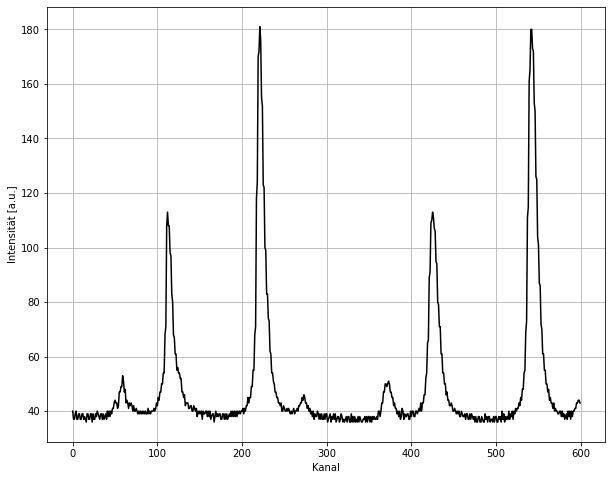

In [5]:
# Create plot for the calibration measurement
fig, ax = create_spectrogram()

# Plot the spectrum
ax.plot(channel_arr, intensity_arr_dict['commercial_HeNe_calibration'], 'k-')

fig.savefig('figs/aufgabe2.1.pdf', bbox_inches='tight')

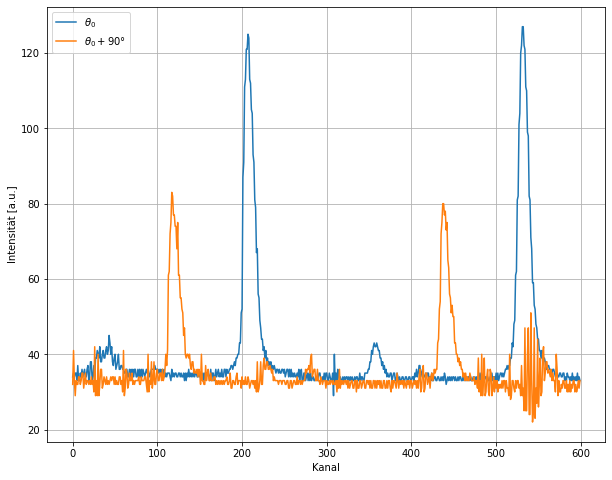

In [9]:
# Subtask 3:
# Create plot for polarization analysis of commercial HeNe
fig, ax = create_spectrogram()

# Plot the spectrum of both polarizer positions
# TBD: Should we add the spectrum without polarizer for comparison?
for array_name, label in zip(
        ['commercial_HeNe_pos_0', 'commercial_HeNe_pos_1'],
        ['$\\theta_0$', '$\\theta_0 + 90°$']
):
    ax.plot(channel_arr, intensity_arr_dict[array_name], label=label)

ax.legend()

fig.savefig('figs/aufgabe2.3.pdf', bbox_inches='tight')

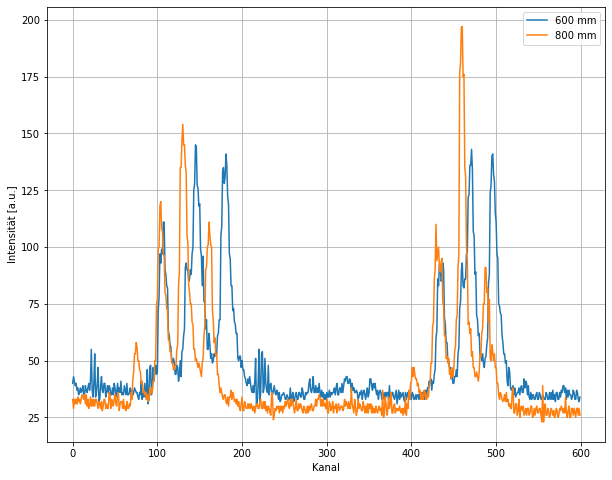

In [10]:
# Subtask 4:
# Create plot for mode analysis of open HeNe for different resonator lengths
fig, ax = create_spectrogram()

# Plot the spectrum of both resonator lengths
# TBD: Display in two separate plots?
for array_name, label in zip(
        ['open_HeNe_600mm', 'open_HeNe_800mm'],
        ['600 mm', '800 mm'],
):
    ax.plot(channel_arr, intensity_arr_dict[array_name], label=label)

ax.legend()

fig.savefig('figs/aufgabe2.4.pdf', bbox_inches='tight')

[  151.33865468    42.00370222 12850.60112859   475.76458197
    30.53195935  9160.28604097    16.983     ]
[1.06755571e+01 2.94814688e+01 1.69489520e+04 8.86371333e+00
 2.49147795e+01 1.31320147e+04 4.38192092e+01]


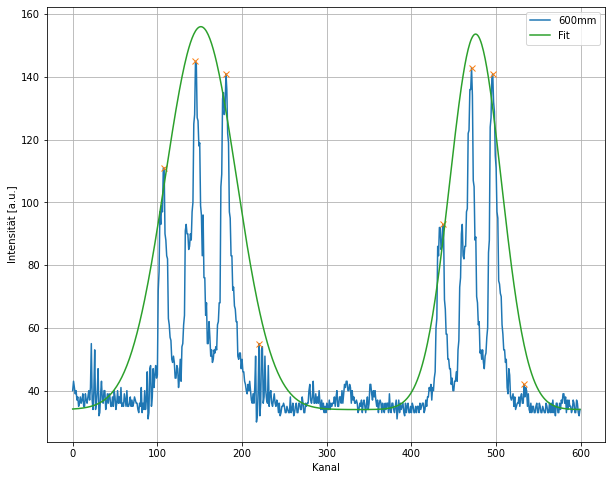

In [26]:
# Subtask 5: Fit der Einhüllenden

#Peak-Array
x_peaks = (108, 145, 181, 220, 437, 471, 496, 533)
y_peaks = (111, 145, 141, 55, 93, 143, 141, 42)
#Gaußkurve zur Fit der Dopplerverbreiterung
def gaussian(x, avrg, dev, max,  offset):
    pre_factor = 1 / np.sqrt(2*np.pi* dev**2)
    exponetial = np.exp(-(x-avrg)**2 / (2* dev**2))
    return max*pre_factor * exponetial + offset

#Lorentzkurve zum Fit der natürlichen Linienverbreiterung (aber vernachlässigbar im vergleich zur Dopplerverbreiterung)
def lorentz(x, w_0, gamma, max, offset):
    l = 1 / ((x**2 - w_0**2)**2 + (gamma**2 * w_0**2)
    return l

"""fit 600mm"""
#Überlagerung 2er Gaußkurven
def gauß_2(x, avrg1, dev1, max1, avrg2, dev2, max2, offset):
    gauß1 = gaussian(x, avrg1, dev1, max1, offset)
    gauß2 = gaussian(x, avrg2, dev2, max2, offset)
    return gauß1 + gauß2

#initial parameters
avrg1 = 151
dev1 = 45
max1 = 10000
avrg2 = 475
dev2 = 45
max2 = 10000
offset = 17
p_0 = (avrg1, dev1, max1, avrg2, dev2, max2, offset)

#parameter boundaries in percent deviation from initial guess
bound = (10,100, 10000, 10,100,10000,0.1)
bound = np.asarray(bound)
bounds=(p_0-np.multiply(p_0,bound/100),p_0+np.multiply(p_0,bound/100))

popt, pcov = curve_fit(gauß_2, x_peaks, y_peaks, p0 = p_0, bounds=bounds)
perr = np.sqrt(np.diag(pcov))
print(popt)
print(perr)

#plot
fig, ax = create_spectrogram()
ax.plot(channel_arr, intensity_arr_dict['open_HeNe_600mm'], label="600mm")
ax.plot(x_peaks, y_peaks, marker="x", ls ='')
ax.plot(channel_arr, gauß_2(channel_arr, *popt), label="Fit")
ax.legend()
fig.savefig('figs/aufgabe2.5.pdf', bbox_inches='tight')

In [9]:
# Subtask 6:
# TODO